## Libraries Used

In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.tree as tr
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_absolute_error, mean_squared_error, precision_score,recall_score, f1_score

## Loading Dataset

In [36]:
# Load the dataset
df = pd.read_csv("Obesity.csv")
print(df.shape)

(2111, 17)


## Preprocessing / Exploring Dataset

In [37]:
df.dtypes

Gender                             object
Age                               float64
Height                            float64
Weight                            float64
family_history_with_overweight     object
FAVC                               object
FCVC                              float64
NCP                               float64
CAEC                               object
SMOKE                              object
CH2O                              float64
SCC                                object
FAF                               float64
TUE                               float64
CALC                               object
MTRANS                             object
NObeyesdad                         object
dtype: object

## Class Imbalance

In [55]:
class_distribution = df['NObeyesdad'].value_counts()
print(class_distribution)

NObeyesdad
Obesity_Type_I         351
Obesity_Type_III       324
Obesity_Type_II        297
Overweight_Level_II    290
Normal_Weight          282
Overweight_Level_I     276
Insufficient_Weight    267
Name: count, dtype: int64


C:\Users\ammar\AppData\Local\Temp\ipykernel_141220\1208213603.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


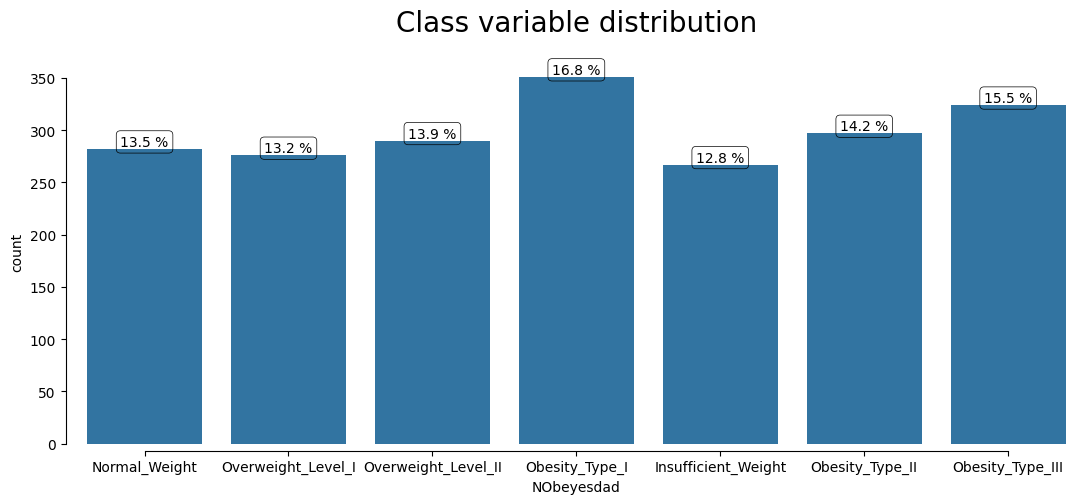

In [56]:
# Plotting the class distribution
plt.figure(figsize=(13, 5))
total = float(len(df))
ax = sns.countplot(x=df['NObeyesdad'])

for p in ax.patches:
    
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,height + 3,'{:1.1f} %'.format((height/total)*100), ha="center",
           bbox=dict(facecolor='none', edgecolor='black', boxstyle='round', linewidth=0.5))

ax.set_title('Class variable distribution', fontsize=20, y=1.05)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
sns.despine(right=True)
sns.despine(offset=5, trim=True)

All 7 classes are somewhat balanced.

In [38]:
# Identifying duplicates
duplicates = df[df.duplicated()]

# Check if there are any duplicates
if duplicates.empty:
    print("No duplicates found.")
else:
    print("Duplicates found:")
    print(duplicates.head())

duplicates.count()

Duplicates found:
     Gender   Age  Height  Weight family_history_with_overweight FAVC  FCVC  \
98   Female  21.0    1.52    42.0                             no   no   3.0   
106  Female  25.0    1.57    55.0                             no  yes   2.0   
174    Male  21.0    1.62    70.0                             no  yes   2.0   
179    Male  21.0    1.62    70.0                             no  yes   2.0   
184    Male  21.0    1.62    70.0                             no  yes   2.0   

     NCP        CAEC SMOKE  CH2O SCC  FAF  TUE       CALC  \
98   1.0  Frequently    no   1.0  no  0.0  0.0  Sometimes   
106  1.0   Sometimes    no   2.0  no  2.0  0.0  Sometimes   
174  1.0          no    no   3.0  no  1.0  0.0  Sometimes   
179  1.0          no    no   3.0  no  1.0  0.0  Sometimes   
184  1.0          no    no   3.0  no  1.0  0.0  Sometimes   

                    MTRANS           NObeyesdad  
98   Public_Transportation  Insufficient_Weight  
106  Public_Transportation        Normal

Gender                            24
Age                               24
Height                            24
Weight                            24
family_history_with_overweight    24
FAVC                              24
FCVC                              24
NCP                               24
CAEC                              24
SMOKE                             24
CH2O                              24
SCC                               24
FAF                               24
TUE                               24
CALC                              24
MTRANS                            24
NObeyesdad                        24
dtype: int64

24 duplicate observation are in the dataset

In [39]:
df.drop_duplicates(inplace=True)
print(df.isnull().sum())
print(df.shape)

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64
(2087, 17)


After removing duplicates from the data set. Observations are reduced to 2087 from 2111.

## Numeric features basic summary

In [40]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,2087.0,24.353090,6.368801,14.00,19.915937,22.847618,26.000000,61.00
Height,2087.0,1.702674,0.093186,1.45,1.630178,1.701584,1.769491,1.98
Weight,2087.0,86.858730,26.190847,39.00,66.000000,83.101100,108.015907,173.00
FCVC,2087.0,2.421466,0.534737,1.00,2.000000,2.396265,3.000000,3.00
NCP,2087.0,2.701179,0.764614,1.00,2.697467,3.000000,3.000000,4.00
CH2O,2087.0,2.004749,0.608284,1.00,1.590922,2.000000,2.466193,3.00
FAF,2087.0,1.012812,0.853475,0.00,0.124505,1.000000,1.678102,3.00
TUE,2087.0,0.663035,0.608153,0.00,0.000000,0.630866,1.000000,2.00


## Skewness and Kurtosis

In [42]:
skewness = (
    df.select_dtypes("number")
    .skew()
    .reset_index()
    .rename(columns={"index": "variable", 0: "skewness"})
)
kurtosis = (
    df.select_dtypes("number")
    .kurtosis()
    .reset_index()
    .rename(columns={"index": "variable", 0: "kurtosis"})
)
skewness_kurtosis = pd.concat([skewness, kurtosis["kurtosis"]], axis=1)
skewness_kurtosis.round(2).style.format(precision=2).background_gradient(
    vmax=3, vmin=-1, cmap="Blues"
)

,variable,skewness,kurtosis
0,Age,1.51,2.77
1,Height,-0.02,-0.56
2,Weight,0.24,-0.71
3,FCVC,-0.45,-0.62
4,NCP,-1.14,0.53
5,CH2O,-0.11,-0.86
6,FAF,0.49,-0.64
7,TUE,0.61,-0.55


## Skewness:

Between -0.5 and 0.5, the data are fairly symmetrical.

Between -1 and -0.5 or between 0.5 to 1, the data are moderately skewed.

Less than -1 or greater than 1, the data are highly skewed.

## Kurtosis:

The general recommendation is that kurtosis should be lower than +2 so that the distribution is not too narrow.
    
Likewise, a kurtosis of less than −2 indicates a distribution that is too flat.

## Numerical and Categorical Features in Dataset

In [14]:
# numerical fearures in dataset are 8
num_feats = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
# categorical (binary) features in dataset are 5
bin_feats = ['Gender', 'family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC']
# caterorical (multi-) features in dataset are 4
nom_feats= ['CAEC', 'CALC', 'MTRANS', 'NObeyesdad']
cat_feats = bin_feats + nom_feats

print('Numerical Features: \n', df[num_feats].head(3),'\n')
print('Categorical Features: \n', df[cat_feats].head(3))

Numerical Features: 
     Age  Height  Weight  FCVC  NCP  CH2O  FAF  TUE
0  21.0    1.62    64.0   2.0  3.0   2.0  0.0  1.0
1  21.0    1.52    56.0   3.0  3.0   3.0  3.0  0.0
2  23.0    1.80    77.0   2.0  3.0   2.0  2.0  1.0 

Categorical Features: 
    Gender family_history_with_overweight FAVC SMOKE  SCC       CAEC  \
0  Female                            yes   no    no   no  Sometimes   
1  Female                            yes   no   yes  yes  Sometimes   
2    Male                            yes   no    no   no  Sometimes   

         CALC                 MTRANS     NObeyesdad  
0          no  Public_Transportation  Normal_Weight  
1   Sometimes  Public_Transportation  Normal_Weight  
2  Frequently  Public_Transportation  Normal_Weight  


## Distribution of Numerical Features

<Figure size 1600x1400 with 0 Axes>

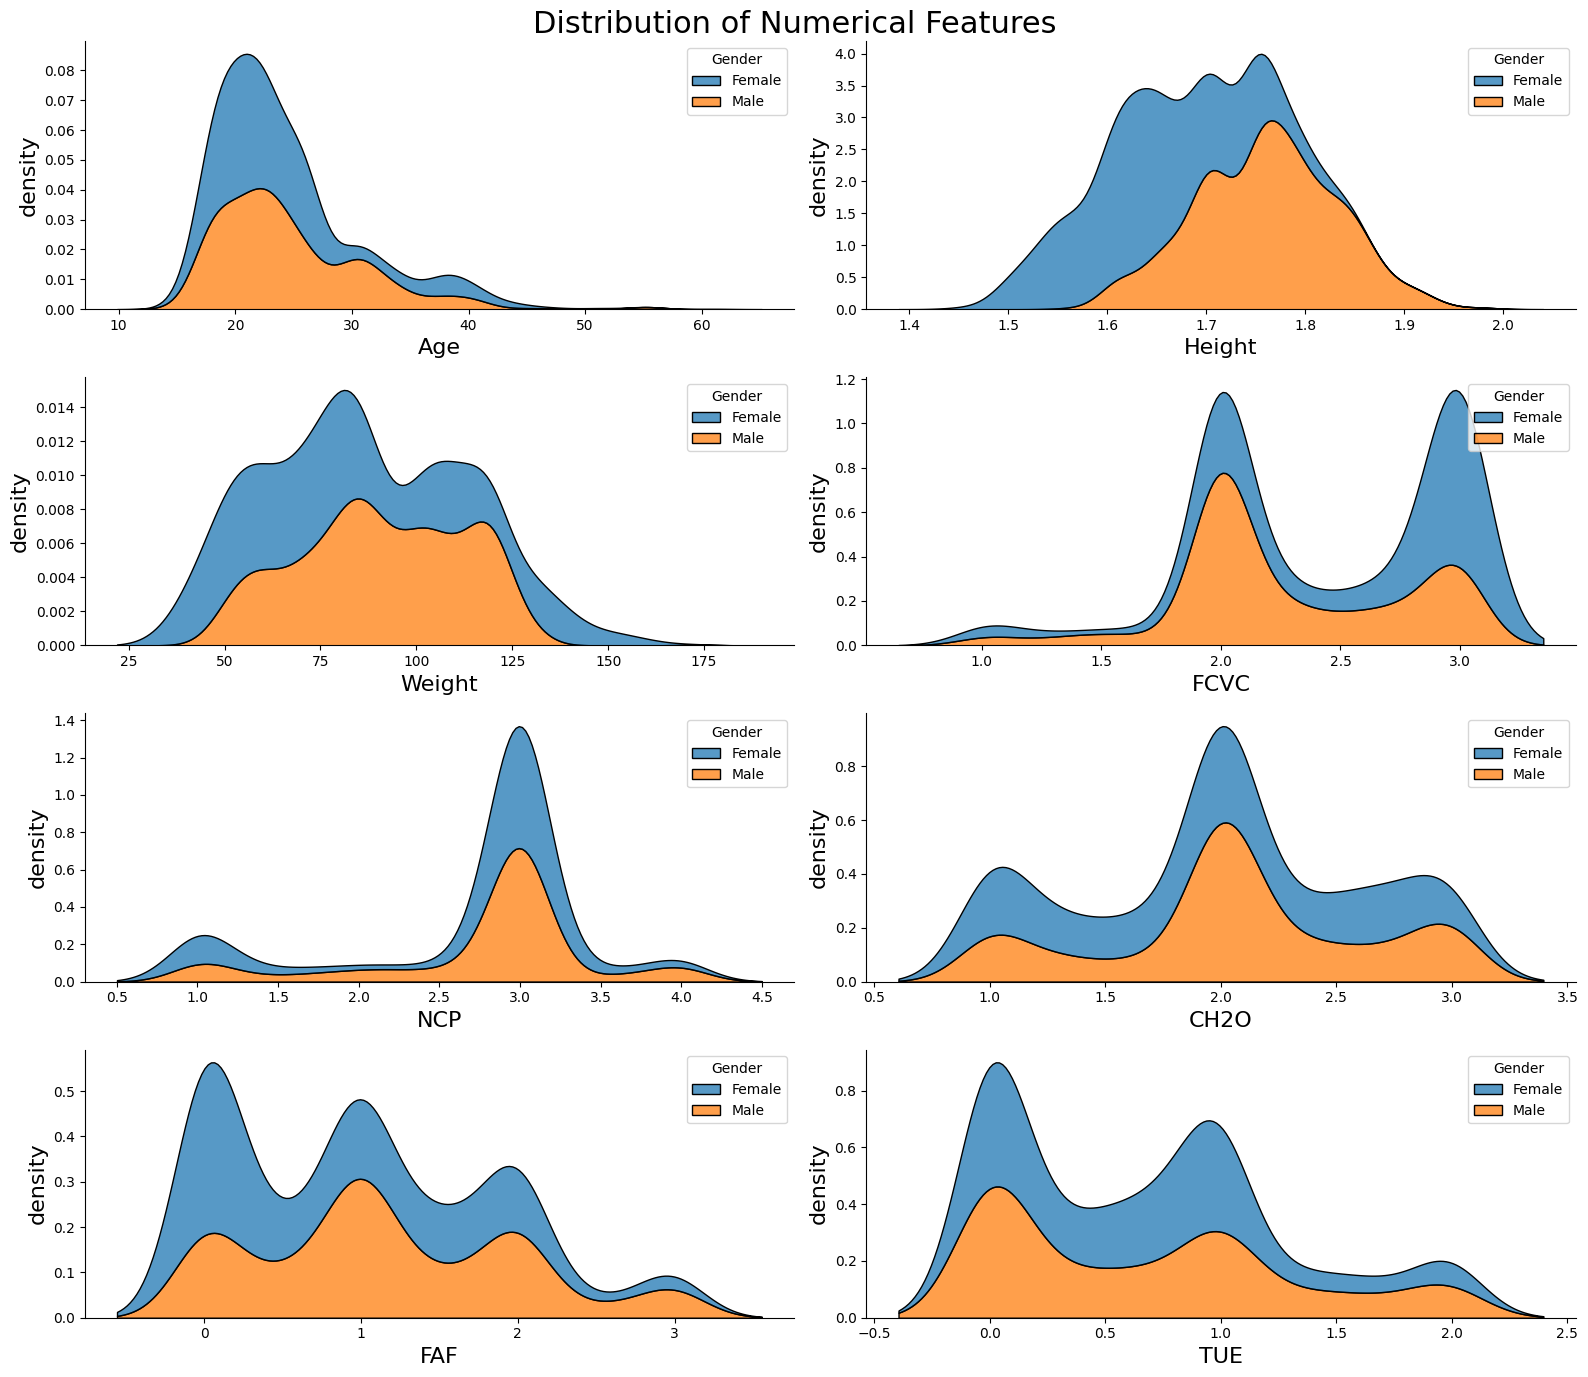

In [71]:
# Distribution of Numerical Features
plt.figure(figsize=(16, 14))

L = len(num_feats)
ncol = 2
nrow = int(np.ceil(L / ncol))

fig, ax = plt.subplots(nrow, ncol, figsize=(16, 14))
fig.subplots_adjust(top=0.92)

i = 0
for col in num_feats:
    row_index = i // ncol
    col_index = i % ncol
    axis = ax[row_index, col_index]
    
    sns.kdeplot(data=df, x=col, hue="Gender", multiple="stack", ax=axis)
    
    axis.set_xlabel(col, fontsize=16)
    axis.set_ylabel("density", fontsize=16)
    axis.set_ylim(0, None)
    
    sns.despine(right=True, ax=axis)
    sns.despine(offset=0, trim=False, ax=axis)
    
    i += 1

plt.suptitle('Distribution of Numerical Features', fontsize=22)
plt.tight_layout()
plt.show()

We can see that 'Age' variable is significantly skewed and has outliers. 

'Height' variable is distributed normally.

## Distribution of Categorical Features

0

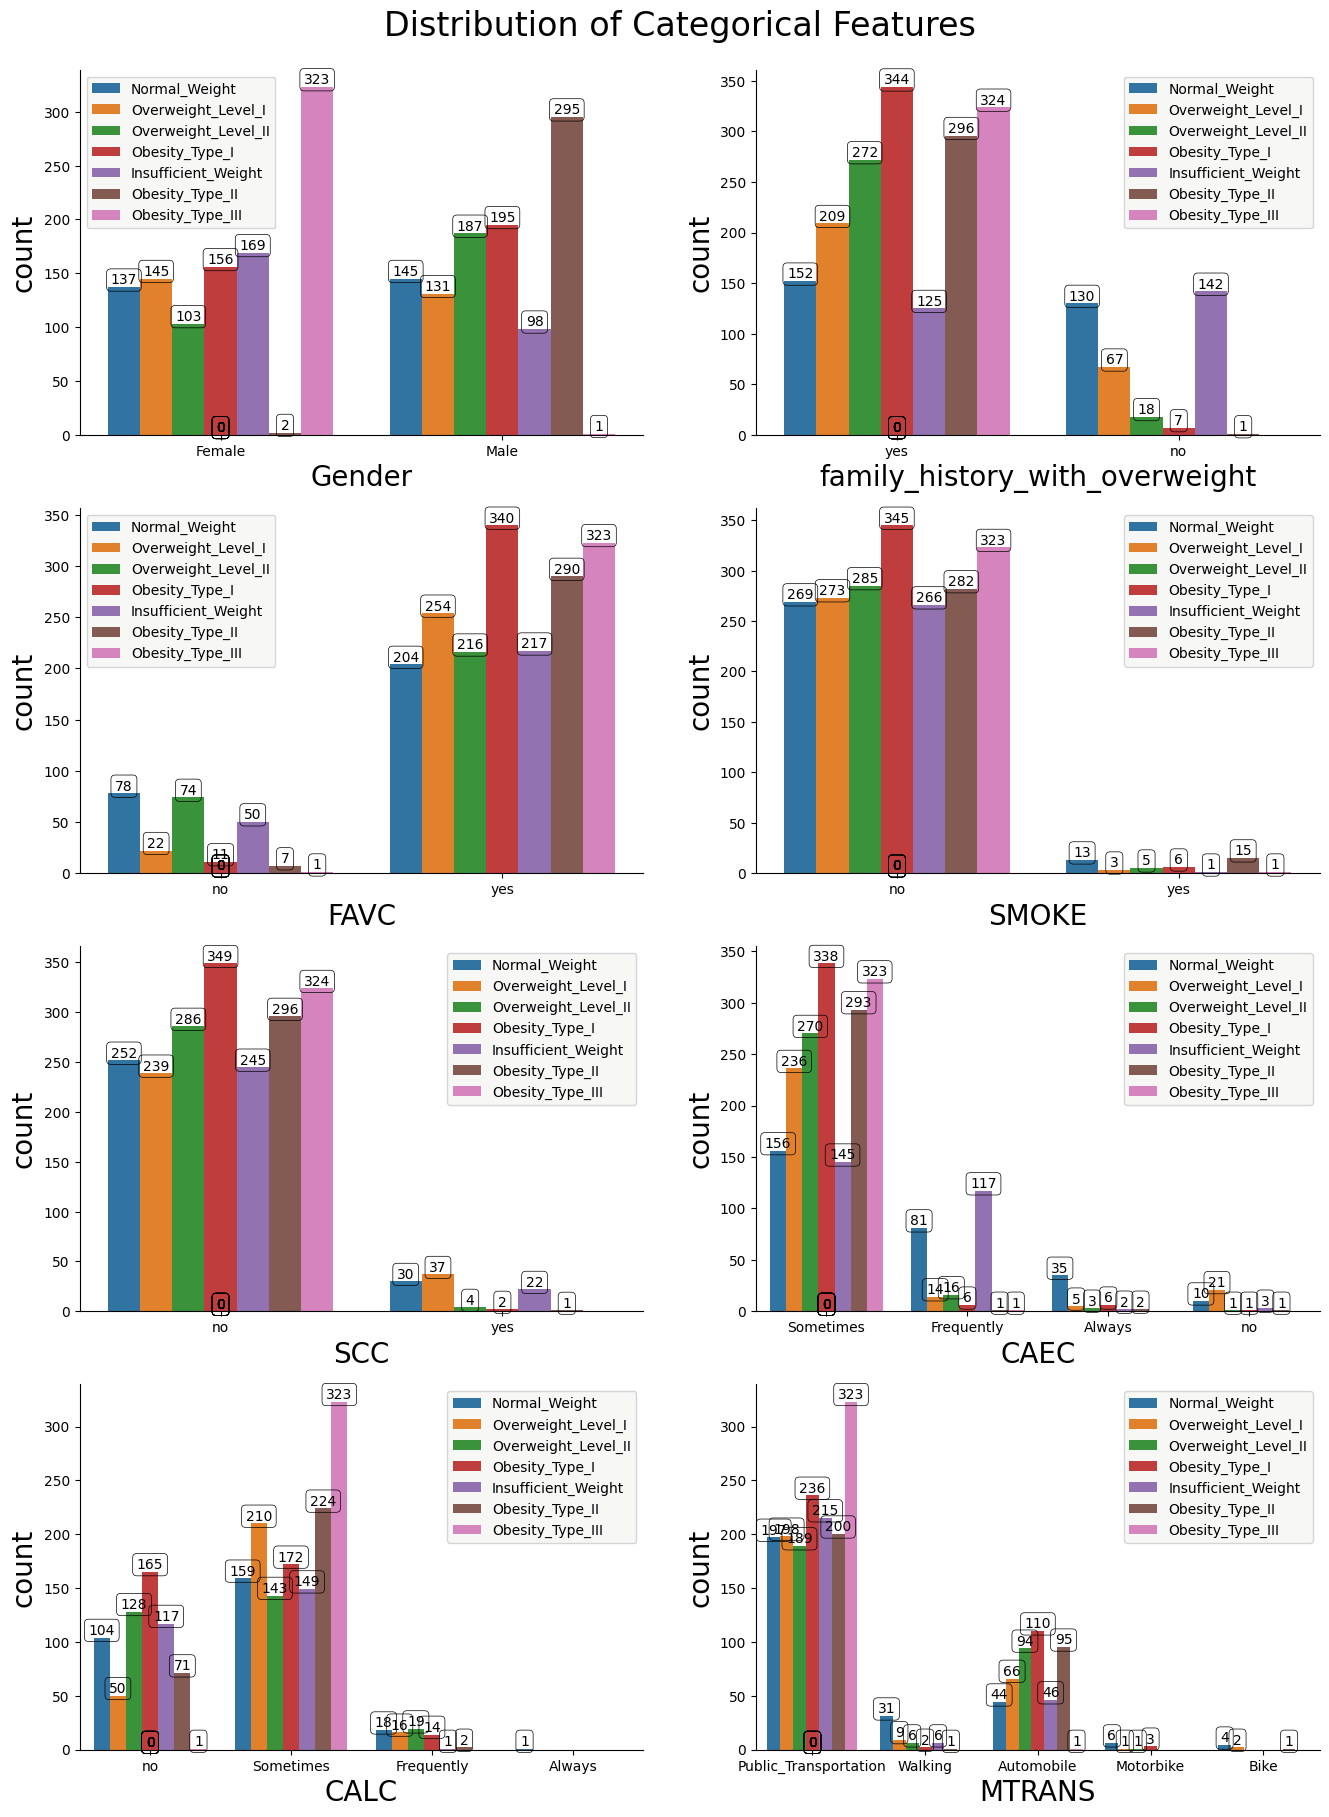

In [72]:
# Distribution of Categorical features
def count_plot(df, cat_feats):    
    L = len(cat_feats)
    ncol = 2
    nrow = int(np.ceil(L / ncol))

    fig, ax = plt.subplots(nrow, ncol, figsize=(16, 20))    
    fig.subplots_adjust(top=0.95)

    i = 0
    for col in cat_feats:
        row_index = i // ncol
        col_index = i % ncol
        axis = ax[row_index, col_index]

        sns.countplot(data=df, x=col, hue="NObeyesdad", ax=axis)
        axis.set_xlabel(col, fontsize=20)
        axis.set_ylabel("count", fontsize=20)
        sns.despine(right=True, ax=axis)
        sns.despine(offset=0, trim=False, ax=axis)
        axis.legend(facecolor='#F6F5F4')

        # Calculate total count for each category
        total_count = df.groupby(col)['NObeyesdad'].count()
        
        # Display count on top of each bar
        for p in axis.patches:
            height = p.get_height()
            category = p.get_x()  # Get the category of the current bar
            axis.text(p.get_x() + p.get_width() / 2., height + 3, '{:.0f}'.format(height), ha="center",
                      bbox=dict(facecolor='none', edgecolor='black', boxstyle='round', linewidth=0.5))
        
        i += 1

    plt.suptitle('Distribution of Categorical Features', fontsize=24)
    return 0

count_plot(df, cat_feats[:-1])

## Categorical Variables Summary:

Target variable 'NObeyesdad' contains 7 unique observations.

CAEC - Consumption of food between meals contains 4 unique observations.

CALC - Consumption of alcohol contains 4 unique observations.

MTRANS - Modes of transportation used contains 5 unique observations.

## Target Variable distrubution based on Gender

In [49]:
df[["Gender", "NObeyesdad"]].value_counts().reset_index().style.format(
    precision=2).background_gradient(cmap="Blues")

,Gender,NObeyesdad,count
0,Female,Obesity_Type_III,323
1,Male,Obesity_Type_II,295
2,Male,Obesity_Type_I,195
3,Male,Overweight_Level_II,187
4,Female,Insufficient_Weight,169
5,Female,Obesity_Type_I,156
6,Female,Overweight_Level_I,145
7,Male,Normal_Weight,145
8,Female,Normal_Weight,137
9,Male,Overweight_Level_I,131


Obesity_Type_II has only 2 female cases and Obesity_Type_III has only 1 male case.

## Target variable vs Age

C:\Users\ammar\AppData\Local\Temp\ipykernel_141220\3036336541.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


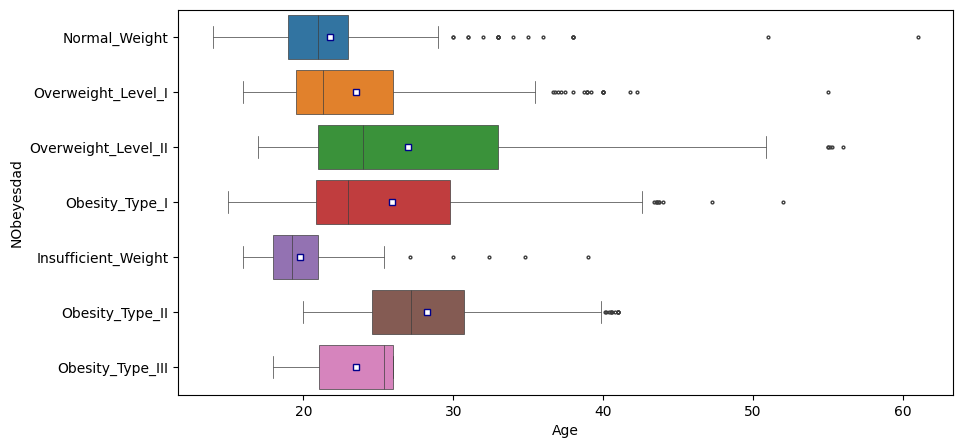

In [51]:
plt.figure(figsize=(10, 5))

sns.boxplot(
    data=df,
    x="Age",
    y="NObeyesdad",
    showmeans=True,
    linewidth=0.5,
    flierprops={"markersize": 2},
    palette="tab10",
    meanprops={
        "marker": "s",
        "markerfacecolor": "white",
        "markeredgecolor": "darkblue",
        "markersize": 5,
    },
)
plt.show()

According to the boxplot, Obesity_Type_III and Obesity_Type_II have no extreme outliers.

## Mapping Class Labels

In [15]:
# Define a dictionary mapping class names to categorical labels
class_labels = {
    'Normal_Weight': 0,
    'Overweight_Level_I': 1,
    'Overweight_Level_II': 2,
    'Obesity_Type_I': 3,
    'Insufficient_Weight': 4,
    'Obesity_Type_II': 5,
    'Obesity_Type_III': 6
}

# Map the class labels to the target variable
df['NObeyesdad_label'] = df['NObeyesdad'].map(class_labels)

## Encoding Categorical Variables

In [16]:
# Data preprocessing
df_encoded = pd.get_dummies(df, columns=['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS'])

# Convert all boolean columns to numerical binary columns
boolean_columns = [col for col in df_encoded.columns if df_encoded[col].dtype == bool]
df_encoded[boolean_columns] = df_encoded[boolean_columns].astype(int)

print(df_encoded.head())

X = df_encoded.drop(['NObeyesdad', 'NObeyesdad_label'], axis=1)
y = df_encoded['NObeyesdad_label']

    Age  Height  Weight  FCVC  NCP  CH2O  FAF  TUE           NObeyesdad  \
0  21.0    1.62    64.0   2.0  3.0   2.0  0.0  1.0        Normal_Weight   
1  21.0    1.52    56.0   3.0  3.0   3.0  3.0  0.0        Normal_Weight   
2  23.0    1.80    77.0   2.0  3.0   2.0  2.0  1.0        Normal_Weight   
3  27.0    1.80    87.0   3.0  3.0   2.0  2.0  0.0   Overweight_Level_I   
4  22.0    1.78    89.8   2.0  1.0   2.0  0.0  0.0  Overweight_Level_II   

   NObeyesdad_label  ...  SCC_yes  CALC_Always  CALC_Frequently  \
0                 0  ...        0            0                0   
1                 0  ...        1            0                0   
2                 0  ...        0            0                1   
3                 1  ...        0            0                1   
4                 2  ...        0            0                0   

   CALC_Sometimes  CALC_no  MTRANS_Automobile  MTRANS_Bike  MTRANS_Motorbike  \
0               0        1                  0            0        

In [17]:
class_labels = df_encoded[['NObeyesdad','NObeyesdad_label']]
class_labels = pd.DataFrame(class_labels)
class_labels_unique_values = class_labels.drop_duplicates(subset=['NObeyesdad'])[['NObeyesdad', 'NObeyesdad_label']]
class_labels_unique_values

,NObeyesdad,NObeyesdad_label
0,Normal_Weight,0
3,Overweight_Level_I,1
4,Overweight_Level_II,2
10,Obesity_Type_I,3
59,Insufficient_Weight,4
68,Obesity_Type_II,5
202,Obesity_Type_III,6


## Splitting Dataset into Train, Validation and Test sets and Scaling the Features

In [18]:
# Split the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=25)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=25)

In [19]:
# Standardize the features using the training set
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


## Decision Tree (DT)

## Parameter Tuning and Cross-Validation

In [24]:
# Define the parameter gridsearch for Decision Tree
param_grid_dt = {
    'max_depth': [2, 5, 10, 11, 13, 15, None],
    'min_samples_split': [2, 5, 10]
}

# Instantiate Decision Tree classifier
dt_clf = DecisionTreeClassifier()

# Perform grid search
grid_search_dt = GridSearchCV(estimator=dt_clf, param_grid=param_grid_dt, cv=5)
grid_search_dt.fit(X_train_scaled, y_train)

# Get the best parameters
best_params_dt = grid_search_dt.best_params_
best_score_dt = grid_search_dt.best_score_

# Make predictions using the best Decision Tree model
best_dt_model = grid_search_dt.best_estimator_
y_pred_dt = best_dt_model.predict(X_test_scaled)

print("Best Parameters for Decision Tree:", best_params_dt)
print("Best cross-validation accuracy score for Decision Tree:", best_score_dt)

Best Parameters for Decision Tree: {'max_depth': 10, 'min_samples_split': 2}
Best cross-validation accuracy score for Decision Tree: 0.9161051792828685


## K-Nearest Neighbours (K-NN)

## Parameter Tuning and Cross-Validation

In [25]:
# Define the parameter grid for K - Nearest Neighbors
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Create the KNN classifier
knn_clf = KNeighborsClassifier()

# Perform grid search with cross-validation
grid_search_knn = GridSearchCV(estimator=knn_clf, param_grid=param_grid_knn, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search_knn.fit(X_train_scaled, y_train)

# Get the best parameters and best score
best_params_knn = grid_search_knn.best_params_
best_score_knn = grid_search_knn.best_score_

print("Best parameters for KNN:", best_params_knn)
print("Best cross-validation accuracy score for KNN:", best_score_knn)


Best parameters for KNN: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
Best cross-validation accuracy score for KNN: 0.8250868525896415


## Support Vector Machine

## Parameter Tuning and Cross-Validation

In [26]:
# Define the parameter grid for Support Vector Machine
param_grid_svc = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

# Create the SVC classifier
svc_clf = SVC()

# Perform grid search with cross-validation
grid_search_svc = GridSearchCV(estimator=svc_clf, param_grid=param_grid_svc, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search_svc.fit(X_train_scaled, y_train)

# Get the best parameters and best score
best_params_svc = grid_search_svc.best_params_
best_score_svc = grid_search_svc.best_score_

print("Best parameters for SVC:", best_params_svc)
print("Best cross-validation accuracy score for SVC:", best_score_svc)


Best parameters for SVC: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Best cross-validation accuracy score for SVC: 0.9512573705179281


## Fitting Algorithms

In [27]:
#KNN
# KNN classifier with best parameters
best_knn_clf = KNeighborsClassifier(n_neighbors=best_params_knn['n_neighbors'],
                                    weights=best_params_knn['weights'],
                                    metric=best_params_knn['metric'])

# Fit the classifier to the training data
best_knn_clf.fit(X_train_scaled, y_train)

# Make predictions on the test data using KNN
y_pred_knn = best_knn_clf.predict(X_test_scaled)


# SVC
# SVC classifier with best parameters
best_svc_clf = SVC(C=best_params_svc['C'],
                   kernel=best_params_svc['kernel'],
                   gamma=best_params_svc['gamma'])

# Fit the classifier to the training data
best_svc_clf.fit(X_train_scaled, y_train)

# Make predictions on the test data using SVC
y_pred_svc = best_svc_clf.predict(X_test_scaled)


# DECISION TREE (DT)
# Decision Tree classifier with best parameters
best_dt_clf = DecisionTreeClassifier(**best_params_dt)

# Fit the classifier to the training data
best_dt_clf.fit(X_train_scaled, y_train)

# Make predictions on the test data using Decision Tree
y_pred_dt = best_dt_clf.predict(X_test_scaled)


## Model Performance

In [28]:
# Calculate mean absolute error
mev_test_knn = mean_absolute_error(y_test, y_pred_knn)
mev_test_dt = mean_absolute_error(y_test, y_pred_dt)
mev_test_svc = mean_absolute_error(y_test, y_pred_svc)

# Calculate accuracy score
accuracy_knn = accuracy_score(y_test, y_pred_knn)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
accuracy_svc = accuracy_score(y_test, y_pred_svc)

# Calculate precision score
precision_knn = precision_score(y_test, y_pred_knn, average='weighted')
precision_dt = precision_score(y_test, y_pred_dt, average='weighted')
precision_svc = precision_score(y_test, y_pred_svc, average='weighted')

# Calculate recall score
recall_knn = recall_score(y_test, y_pred_knn, average='weighted')
recall_dt = recall_score(y_test, y_pred_dt, average='weighted')
recall_svc = recall_score(y_test, y_pred_svc, average='weighted')

# Calculate F1 score
f1_knn = f1_score(y_test, y_pred_knn, average='weighted')
f1_dt = f1_score(y_test, y_pred_dt, average='weighted')
f1_svc = f1_score(y_test, y_pred_svc, average='weighted')

# Calculate confusion matrix
cm_knn = confusion_matrix(y_test, y_pred_knn)
cm_dt = confusion_matrix(y_test, y_pred_dt)
cm_svc = confusion_matrix(y_test, y_pred_svc)

print('K - Nearest Neighbors (K-NN):')
print("KNN Model - Mean Absolute Error:", mev_test_knn)
print("KNN Model - Accuracy:", accuracy_knn)
print("KNN Model - Precision:", precision_knn)
print("KNN Model - Recall:", recall_knn)
print("KNN Model - F1 Score:", f1_knn)
print("KNN Model - Confusion Matrix:\n", cm_knn,'\n')

print('Support Vector Machine (SVM):')
print("SVC Model - Mean Absolute Error:", mev_test_svc)
print("SVC Model - Accuracy:", accuracy_svc)
print("SVC Model - Precision:", precision_svc)
print("SVC Model - Recall:", recall_svc)
print("SVC Model - F1 Score:", f1_svc)
print("SVC Model - Confusion Matrix:\n",cm_svc,'\n')

print('Decision tree (DT):')
print("DT Model - Mean Absolute Error:", mev_test_dt)
print("DT Model - Accuracy:", accuracy_dt)
print("DT Model - Precision:", precision_dt)
print("DT Model - Recall:", recall_dt)
print("DT Model - F1 Score:", f1_dt)
print("DT Model - Confusion Matrix:\n",cm_dt,'\n')

K - Nearest Neighbors (K-NN):
KNN Model - Mean Absolute Error: 0.34688995215311
KNN Model - Accuracy: 0.8516746411483254
KNN Model - Precision: 0.8485017464257305
KNN Model - Recall: 0.8516746411483254
KNN Model - F1 Score: 0.8486100440824539
KNN Model - Confusion Matrix:
 [[35  3  7  1  9  2  0]
 [ 7 40  2  6  0  0  0]
 [ 0  4 49  3  1  1  0]
 [ 0  0  1 64  1  3  1]
 [ 5  1  0  0 47  0  0]
 [ 2  0  0  0  0 57  1]
 [ 0  0  0  0  0  1 64]] 

Support Vector Machine (SVM):
SVC Model - Mean Absolute Error: 0.0430622009569378
SVC Model - Accuracy: 0.9665071770334929
SVC Model - Precision: 0.9679348663841039
SVC Model - Recall: 0.9665071770334929
SVC Model - F1 Score: 0.9665358728478425
SVC Model - Confusion Matrix:
 [[50  6  0  0  1  0  0]
 [ 1 52  2  0  0  0  0]
 [ 0  2 56  0  0  0  0]
 [ 0  0  0 70  0  0  0]
 [ 0  0  0  0 53  0  0]
 [ 0  0  0  1  0 58  1]
 [ 0  0  0  0  0  0 65]] 

Decision tree (DT):
DT Model - Mean Absolute Error: 0.12679425837320574
DT Model - Accuracy: 0.9210526315789

## Confusion Matrix for K - Nearest Neighbours (K-NN)

In [30]:
# Calculate the number of unique classes in test dataset
n_classes = len(np.unique(y_test))

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_knn)

# Variables to store true positives, true negatives, false positives, and false negatives
true_positives = np.zeros(n_classes)
true_negatives = np.zeros(n_classes)
false_positives = np.zeros(n_classes)
false_negatives = np.zeros(n_classes)

# Iterate over each class and calculate the TP, TN, FP, FN
for i in range(n_classes):
    true_positives[i] = cm[i, i]
    false_positives[i] = cm[:, i].sum() - cm[i, i]
    false_negatives[i] = cm[i, :].sum() - cm[i, i]
    true_negatives[i] = cm.sum() - (true_positives[i] + false_positives[i] + false_negatives[i])

# Print the results
for i in range(n_classes):
    print(f"Class {i}:")
    print(f"True Positives: {true_positives[i]}")
    print(f"True Negatives: {true_negatives[i]}")
    print(f"False Positives: {false_positives[i]}")
    print(f"False Negatives: {false_negatives[i]}")
    print()

# Calculate overall values by aggregating across all classes
overall_true_positives_knn = true_positives.sum()
overall_true_negatives_knn = true_negatives.sum()
overall_false_positives_knn = false_positives.sum()
overall_false_negatives_knn = false_negatives.sum()

print("Overall:")
print(f"True Positives: {overall_true_positives_knn}")
print(f"True Negatives: {overall_true_negatives_knn}")
print(f"False Positives: {overall_false_positives_knn}")
print(f"False Negatives: {overall_false_negatives_knn}")


Class 0:
True Positives: 35.0
True Negatives: 347.0
False Positives: 14.0
False Negatives: 22.0

Class 1:
True Positives: 40.0
True Negatives: 355.0
False Positives: 8.0
False Negatives: 15.0

Class 2:
True Positives: 49.0
True Negatives: 350.0
False Positives: 10.0
False Negatives: 9.0

Class 3:
True Positives: 64.0
True Negatives: 338.0
False Positives: 10.0
False Negatives: 6.0

Class 4:
True Positives: 47.0
True Negatives: 354.0
False Positives: 11.0
False Negatives: 6.0

Class 5:
True Positives: 57.0
True Negatives: 351.0
False Positives: 7.0
False Negatives: 3.0

Class 6:
True Positives: 64.0
True Negatives: 351.0
False Positives: 2.0
False Negatives: 1.0

Overall:
True Positives: 356.0
True Negatives: 2446.0
False Positives: 62.0
False Negatives: 62.0


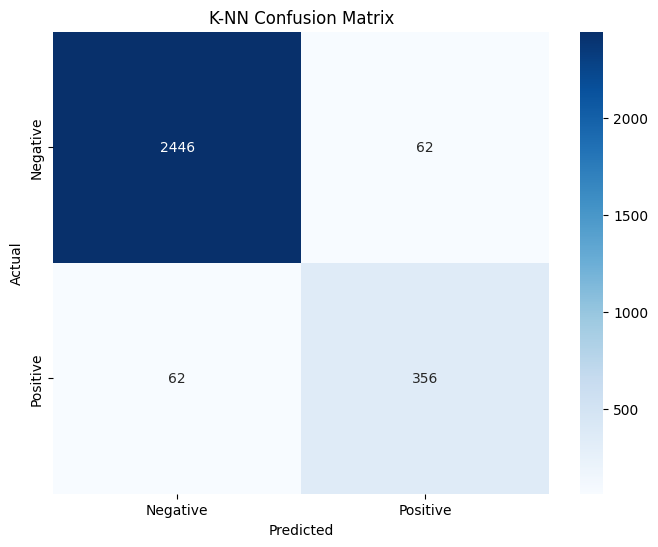

In [52]:
# Define confusion matrix
conf_matrix = np.array([[overall_true_negatives_knn, overall_false_positives_knn],
                        [overall_false_negatives_knn, overall_true_positives_knn]])

# Define class labels
class_labels = ['Negative', 'Positive']

# Compute color scale limits
vmin = np.min(conf_matrix)
vmax = np.max(conf_matrix)

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='.0f', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, vmin=vmin, vmax=vmax)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('K-NN Confusion Matrix')
plt.show()

## Confusion Matrix for Decision Tree (DT)

In [31]:
# Calculate the number of unique classes in test dataset
n_classes = len(np.unique(y_test))

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_dt)

# Variables to store true positives, true negatives, false positives, and false negatives
true_positives = np.zeros(n_classes)
true_negatives = np.zeros(n_classes)
false_positives = np.zeros(n_classes)
false_negatives = np.zeros(n_classes)

# Iterate over each class and calculate the TP, TN, FP, FN
for i in range(n_classes):
    true_positives[i] = cm[i, i]
    false_positives[i] = cm[:, i].sum() - cm[i, i]
    false_negatives[i] = cm[i, :].sum() - cm[i, i]
    true_negatives[i] = cm.sum() - (true_positives[i] + false_positives[i] + false_negatives[i])

# Print the results
for i in range(n_classes):
    print(f"Class {i}:")
    print(f"True Positives: {true_positives[i]}")
    print(f"True Negatives: {true_negatives[i]}")
    print(f"False Positives: {false_positives[i]}")
    print(f"False Negatives: {false_negatives[i]}")
    print()

# Calculate overall values by aggregating across all classes
overall_true_positives_dt = true_positives.sum()
overall_true_negatives_dt = true_negatives.sum()
overall_false_positives_dt = false_positives.sum()
overall_false_negatives_dt = false_negatives.sum()

print("Overall:")
print(f"True Positives: {overall_true_positives_dt}")
print(f"True Negatives: {overall_true_negatives_dt}")
print(f"False Positives: {overall_false_positives_dt}")
print(f"False Negatives: {overall_false_negatives_dt}")


Class 0:
True Positives: 46.0
True Negatives: 353.0
False Positives: 8.0
False Negatives: 11.0

Class 1:
True Positives: 47.0
True Negatives: 353.0
False Positives: 10.0
False Negatives: 8.0

Class 2:
True Positives: 56.0
True Negatives: 354.0
False Positives: 6.0
False Negatives: 2.0

Class 3:
True Positives: 64.0
True Negatives: 344.0
False Positives: 4.0
False Negatives: 6.0

Class 4:
True Positives: 51.0
True Negatives: 362.0
False Positives: 3.0
False Negatives: 2.0

Class 5:
True Positives: 56.0
True Negatives: 357.0
False Positives: 1.0
False Negatives: 4.0

Class 6:
True Positives: 65.0
True Negatives: 352.0
False Positives: 1.0
False Negatives: 0.0

Overall:
True Positives: 385.0
True Negatives: 2475.0
False Positives: 33.0
False Negatives: 33.0


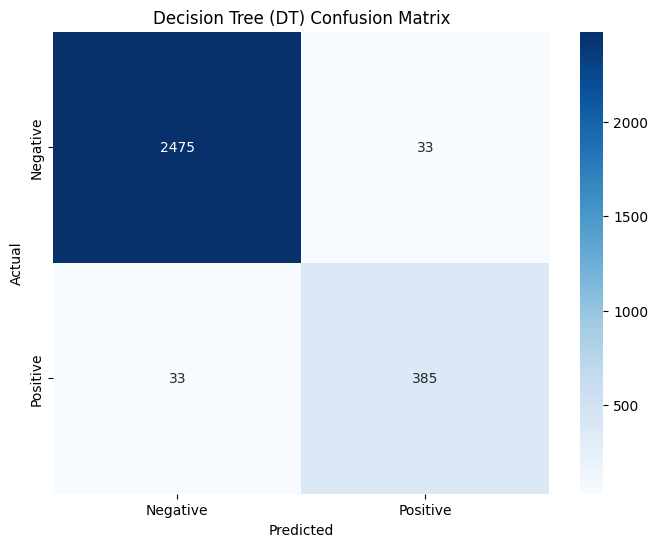

In [53]:
# Define confusion matrix
conf_matrix = np.array([[overall_true_negatives_dt, overall_false_positives_dt],
                        [overall_false_negatives_dt, overall_true_positives_dt]])

# Define class labels
class_labels = ['Negative', 'Positive']

# Compute color scale limits
vmin = np.min(conf_matrix)
vmax = np.max(conf_matrix)

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='.0f', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, vmin=vmin, vmax=vmax)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Decision Tree (DT) Confusion Matrix')
plt.show()

## Confusion Matrix for Support Vector Machine (SVC)

In [33]:
# Calculate the number of unique classes in test dataset
n_classes = len(np.unique(y_test))

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_svc)

# Variables to store true positives, true negatives, false positives, and false negatives
true_positives = np.zeros(n_classes)
true_negatives = np.zeros(n_classes)
false_positives = np.zeros(n_classes)
false_negatives = np.zeros(n_classes)

# Iterate over each class and calculate the TP, TN, FP, FN
for i in range(n_classes):
    true_positives[i] = cm[i, i]
    false_positives[i] = cm[:, i].sum() - cm[i, i]
    false_negatives[i] = cm[i, :].sum() - cm[i, i]
    true_negatives[i] = cm.sum() - (true_positives[i] + false_positives[i] + false_negatives[i])

# Print the results
for i in range(n_classes):
    print(f"Class {i}:")
    print(f"True Positives: {true_positives[i]}")
    print(f"True Negatives: {true_negatives[i]}")
    print(f"False Positives: {false_positives[i]}")
    print(f"False Negatives: {false_negatives[i]}")
    print()

# Calculate overall values by aggregating across all classes
overall_true_positives_svc = true_positives.sum()
overall_true_negatives_svc = true_negatives.sum()
overall_false_positives_svc = false_positives.sum()
overall_false_negatives_svc = false_negatives.sum()

print("Overall:")
print(f"True Positives: {overall_true_positives_svc}")
print(f"True Negatives: {overall_true_negatives_svc}")
print(f"False Positives: {overall_false_positives_svc}")
print(f"False Negatives: {overall_false_negatives_svc}")


Class 0:
True Positives: 50.0
True Negatives: 360.0
False Positives: 1.0
False Negatives: 7.0

Class 1:
True Positives: 52.0
True Negatives: 355.0
False Positives: 8.0
False Negatives: 3.0

Class 2:
True Positives: 56.0
True Negatives: 358.0
False Positives: 2.0
False Negatives: 2.0

Class 3:
True Positives: 70.0
True Negatives: 347.0
False Positives: 1.0
False Negatives: 0.0

Class 4:
True Positives: 53.0
True Negatives: 364.0
False Positives: 1.0
False Negatives: 0.0

Class 5:
True Positives: 58.0
True Negatives: 358.0
False Positives: 0.0
False Negatives: 2.0

Class 6:
True Positives: 65.0
True Negatives: 352.0
False Positives: 1.0
False Negatives: 0.0

Overall:
True Positives: 404.0
True Negatives: 2494.0
False Positives: 14.0
False Negatives: 14.0


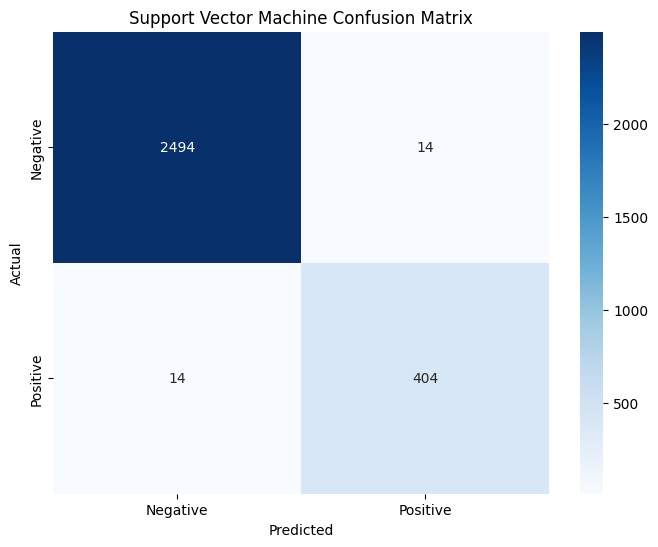

In [54]:
# Define confusion matrix
conf_matrix = np.array([[overall_true_negatives_svc, overall_false_positives_svc],
                        [overall_false_negatives_svc, overall_true_positives_svc]])

# Define class labels
class_labels = ['Negative', 'Positive']

# Compute color scale limits
vmin = np.min(conf_matrix)
vmax = np.max(conf_matrix)

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='.0f', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, vmin=vmin, vmax=vmax)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Support Vector Machine Confusion Matrix')
plt.show()